# Praktikum 1

Instalasi Annoy dulu untuk langkah awal.

In [ ]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551809 sha256=73faeb563d46368d7699607ed1e58cfa3f9f8c2839355c3c80a56c9d6ed7d354
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


Langkah 1

Membandingkan dua pendekatan pencarian tetangga terdekat (Nearest Neighbor atau NN) pada dataset sederhana
*   Metode Exact NN (brute force): Pendekatan akurat tapi lambat, yang menghitung jarak ke semua titik secara eksplisit.
*   Metode Approximate NN menggunakan Annoy: Pendekatan cepat tapi kurang akurat (aproksimasi), yang menggunakan struktur pohon (trees) untuk mempercepat pencarian.

Kesimpulan:

Kode dibawah mengahasilkan bahwa annoy bisa mempercepat pencarian NN hingga 10-100x dibanding brute force, dengan sedikit pengorbanan akurasi (recall >95% biasanya). Cocok untuk dataset besar (jutaan titik) di aplikasi real-time namun kelemahanya memawakn waktu dan memori cukup besar.



Euclidean

Exact NN index: [64040 64186 88792]
Exact NN jarak: [0.         0.15797867 0.25332711]
Waktu Exact: 19.0794 ms

Annoy NN index: [64040, 64186, 88792]
Annoy NN jarak: [np.float64(0.0), np.float64(0.1579786703429142), np.float64(0.2533271079062769)]
Waktu Annoy: 0.2425 ms


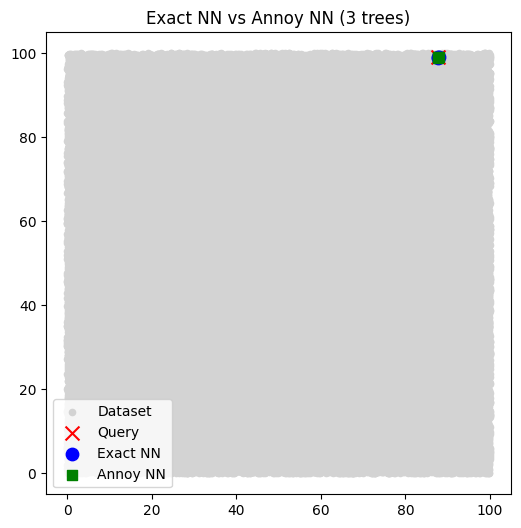

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 100000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

Angular

Exact NN index: [64040  1310  1267]
Exact NN jarak (angular): [2.22044605e-16 6.23343599e-11 7.57095497e-11]
Waktu Exact: 11.2152 ms

Annoy NN index: [64040, 1310, 9720]
Annoy NN jarak (angular): [np.float64(2.220446049250313e-16), np.float64(6.233435989599911e-11), np.float64(6.8060926894375484e-09)]
Waktu Annoy: 0.123 ms


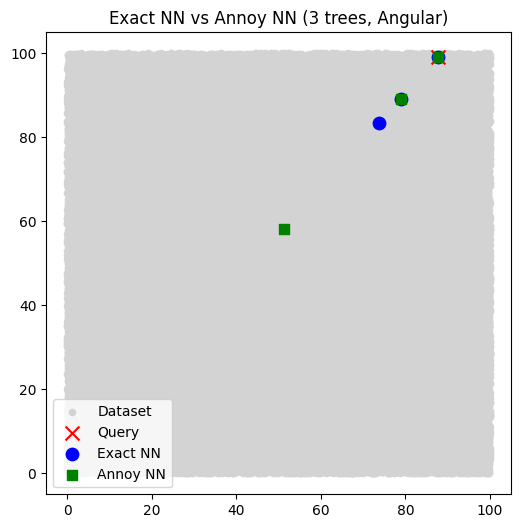

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 100000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random) - saran: ganti ke X[0] untuk konsistensi
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force) - DIRUBAH: Gunakan angular distance (1 - cosine sim)
start = time.time()
cos_sim = np.dot(X, query) / (np.linalg.norm(X, axis=1) * np.linalg.norm(query))
distances = 1 - cos_sim  # Angular distance
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak (angular):", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree) - DIRUBAH: Gunakan 'angular' metric
f = 2  # dimensi
t = AnnoyIndex(f, 'angular')  # Ubah ke 'angular'
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

# Hitung jarak Annoy untuk verifikasi (angular)
ann_dist = [1 - (np.dot(X[i], query) / (np.linalg.norm(X[i]) * np.linalg.norm(query))) for i in idx_ann]

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak (angular):", ann_dist)
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil (tetap sama, karena plot Euclidean-based)
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees, Angular)")
plt.show()

Hasil :

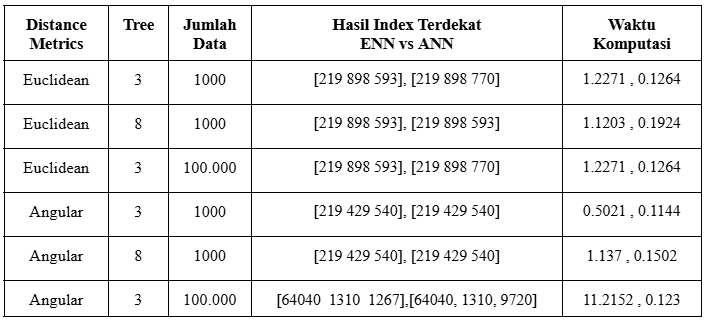

Percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

Euclidean

In [ ]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 1000000  # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = euclidean_distances(query, X)[0]   # hitung semua jarak
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 8

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [405473  87923 819722 293133 570683]
Exact NN time: 0.17 seconds
Annoy result: [312129, 578430, 264537, 398800, 299484]
Annoy time: 0.0 seconds


Angular

In [ ]:
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 1000000  # 50 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = cosine_distances(query, X)[0]   # DIRUBAH: Gunakan cosine_distances untuk angular (1 - cosine sim)
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'angular')  # DIRUBAH: Ubah ke 'angular'
n_trees = 8

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

# DIRUBAH: Hitung jarak Annoy untuk verifikasi (cosine distance)
annoy_distances = cosine_distances(query, X[annoy_idx])[0]

print("Annoy result:", annoy_idx)
print("Annoy distances:", annoy_distances)
print("Annoy time:", round(annoy_time, 3), "seconds")

Exact NN result: [898039  66711 110858  42057 381039]
Exact NN time: 0.22 seconds
Annoy result: [946051, 956803, 688805, 596833, 954283]
Annoy distances: [0.04843122 0.05276728 0.05533743 0.05659527 0.05882341]
Annoy time: 0.0 seconds


Hasil:
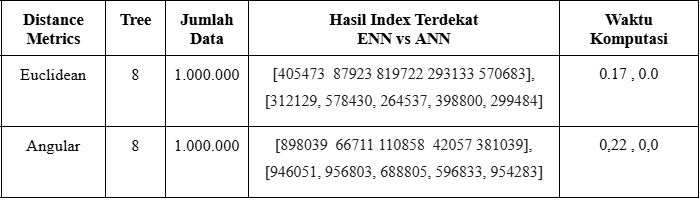